## Advanced Automation - Project Abalone (Group 1) - Regression

Margarida Gralha (100222),
Tiago Neves (100272),
Rodrigo Amorim (100702)

## Import all libraries

In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy
import os
import random
import itertools

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import stats
from sklearn.metrics import  mean_squared_error
from scipy.stats import pearsonr
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, KFold,StratifiedKFold, cross_val_score, cross_validate, LeaveOneOut
from sklearn import metrics
from sklearn.linear_model import Ridge
from random import sample

## Data processing

In [2]:
## LOAD DATASET
abl_df = pd.read_csv(os.path.abspath('abalone_data.csv'))
abl_df.head()
seed = 1
random_seed = 1

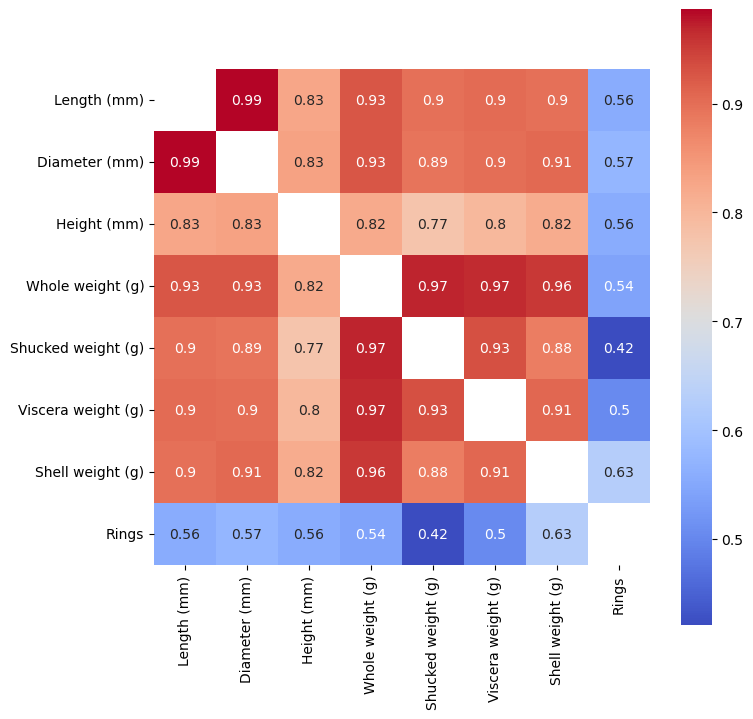

In [3]:
## CORRELATION MATRIX
# Calculate correlation between each numeric column
abl_df_corr = abl_df.corr(method='pearson', numeric_only = True)

# Calculate the p-value, as the second element of the response from the pearsonr function. 
abl_df_pval = abl_df.corr(numeric_only = True, method=lambda x, y: pearsonr(x, y)[1])

# Establish the mask, to hide values without a given statistical significance
ptg_stat_sig = 0.1/100
mask = abl_df_pval > ptg_stat_sig

# Plot the correlation matrix using seaborn's heatmap function
plt.subplots(figsize=(8, 8))
abl_corr_heatmap = sns.heatmap(abl_df_corr, mask = mask, square = True, cmap = 'coolwarm', annot = True)

In [4]:
## AVERAGE RING AMOUNT BASED ON SEX

from statistics import median
from itertools import compress

# Find indexes of each sex
M_idxs = list(compress(range(len((abl_df['Sex'] == 'M'))), (abl_df['Sex'] == 'M')))
F_idxs = list(compress(range(len((abl_df['Sex'] == 'F'))), (abl_df['Sex'] == 'F')))
I_idxs = list(compress(range(len((abl_df['Sex'] == 'I'))), (abl_df['Sex'] == 'I')))

# List of ring amount for each sex
M_Rings = list(abl_df['Rings'][i] for i in M_idxs)
F_Rings = list(abl_df['Rings'][i] for i in F_idxs)
I_Rings = list(abl_df['Rings'][i] for i in I_idxs)

# Print the average ring amount of each sex
print('M_Rings_avg = {:d}'.format(int(round(sum(M_Rings)/len(M_Rings),0))))
print('F_Rings_avg = {0}'.format(int(round(sum(F_Rings)/len(F_Rings),0))))
print('I_Rings_avg = {0}'.format(int(round(sum(I_Rings)/len(I_Rings),0))))

# Print the median ring amount of each sex
print('M_Rings_med = {:d}'.format(int(median(M_Rings))))
print('F_Rings_med = {0}'.format(int(median(F_Rings))))
print('I_Rings_med = {0}'.format(int(median(I_Rings))))

M_Rings_avg = 11
F_Rings_avg = 11
I_Rings_avg = 8
M_Rings_med = 10
F_Rings_med = 10
I_Rings_med = 8


## Multiple Linear Regression (Validation set Approach)


Rings = 6.4329 + 14.5810 * Shell weight_g
R^2: 0.3629
Test MSE: 6.2341


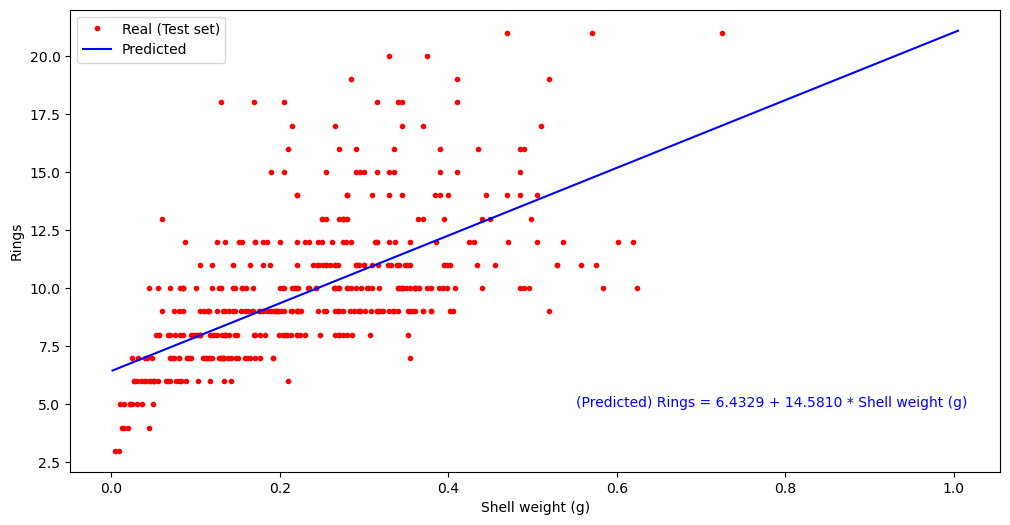

In [5]:
## LINEAR REGRESSION WITH A SINGLE NUMERIC PREDICTOR

# Choose numeric predictor for the output
x_single = abl_df['Shell weight (g)'].values.reshape(-1, 1)
y_single = abl_df['Rings'].values.reshape(-1, 1)

seed = 1
X_train, X_test, y_train, y_test = train_test_split(x_single, y_single.reshape(-1,1), train_size=0.9, random_state=seed)

# Compute the linear regression
regr_test = LinearRegression()
regr_test.fit(X_train, y_train)

# Print linear regression expression
print('Rings = {:.4f} + {:.4f} * Shell weight_g'.format(regr_test.intercept_[0], regr_test.coef_[0][0]))

# Compute R^2
y_pred = regr_test.predict(X_test)
mse = mean_squared_error(y_true=y_test, y_pred=y_pred, squared=True)
r2_value = r2_score(y_test, y_pred)
print('R^2: {:.4f}'.format(r2_value))
print('Test MSE: {:.4f}'.format(mse))

# Plot regression line and data
limits_Length_mm = np.array([min(x_single), max(x_single)])
Rings_pred_vals = regr_test.intercept_[0] + regr_test.coef_[0][0]*limits_Length_mm

plt.rcParams['figure.figsize'] = [12, 6]
plt.plot(X_test, y_test, '.r', label='Real (Test set)')
plt.plot(limits_Length_mm, Rings_pred_vals, 'b-', label='Predicted')
plt.legend()
plt.xlabel('Shell weight (g)')
plt.ylabel('Rings')
regression_expression = "(Predicted) Rings = 6.4329 + 14.5810 * Shell weight (g)"
plt.text(0.7545, 0.15, regression_expression, ha='center', va='center', color='blue', transform=plt.gca().transAxes)
plt.show()

In [6]:
## LINEAR REGRESSION WITH ALL NUMERIC PREDICTORS AND SEX_I CONSIDERATION

# Define predictors and output
dummies = pd.get_dummies(abl_df,columns = ['Sex'],dtype=int)
x_m = abl_df.drop(columns = ['Sex','Rings']).astype('float64')
x_m = pd.concat([x_m, dummies['Sex_I']], axis=1)
y_m = abl_df['Rings'].values.reshape(-1, 1)

# Define test and training data
seed = 1
X_train, X_test, y_train, y_test = train_test_split(x_m, y_m.reshape(-1,1), train_size=0.9, random_state=seed)

# Compute the linear regression
regr = LinearRegression()
regr.fit(X_train,y_train)

# Print linear regression expression
print('Rings = {:.4f} + {:.4f} * Length_mm + {:.4f} * Diameter_mm + {:.4f} * Height_mm + {:.4f} * Whole weight_g + {:.4f} * Shucked weight_g + {:.4f} * Viscera weight_g + {:.4f} * Shell weight_g + {:.4f} * Sex_I'.format(regr.intercept_[0], regr.coef_[0][0], regr.coef_[0][1], regr.coef_[0][2], regr.coef_[0][3], regr.coef_[0][4], regr.coef_[0][5], regr.coef_[0][6], regr.coef_[0][7]))

# Compute MSE and R^2
y_pred = regr.predict(X_test)
mse = mean_squared_error(y_true=y_test, y_pred=y_pred, squared=True)
r2_value = r2_score(y_test, y_pred)
print('R^2: {:.4f}'.format(r2_value))
print('Test MSE: {:.4f}'.format(mse))

#Compute f-statistic
X_train = sm.add_constant(X_train)
mreg = sm.OLS(y_train, X_train).fit()
display(mreg.summary())

Rings = 3.8991 + -0.6801 * Length_mm + 11.3616 * Diameter_mm + 10.6141 * Height_mm + 8.6733 * Whole weight_g + -19.6357 * Shucked weight_g + -9.5101 * Viscera weight_g + 8.8391 * Shell weight_g + -0.8251 * Sex_I
R^2: 0.5446
Test MSE: 4.4565


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.537
Model:                            OLS   Adj. R-squared:                  0.536
Method:                 Least Squares   F-statistic:                     543.4
Date:                Thu, 11 Jan 2024   Prob (F-statistic):               0.00
Time:                        23:08:05   Log-Likelihood:                -8298.8
No. Observations:                3759   AIC:                         1.662e+04
Df Residuals:                    3750   BIC:                         1.667e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  3.8991      0.300     13.010      0.000       3.312       4.487
Length (mm)           -0.6801      1.906     -0.357      0.721      -4.417       3.057
Diameter (mm)         11.3616      2.349      4.837      0.000       6.757      15.966
Height (mm)           10.6141      1.578      6.726      0.000       7.520      13.708
Whole weight (g)       8.6733      0.761     11.397      0.000       7.181      10.165
Shucked weight (g)   -19.6357      0.860    -22.837      0.000     -21.321     -17.950
Viscera weight (g)    -9.5101      1.361     -6.988      0.000     -12.178      -6.842
Shell weight (g)       8.8391      1.180      7.489      0.000       6.525      11.153
Sex_I                 -0.8251      0.095     -8.712      0.000      -1.011      -0.639
==============================================================================
Omnibus:                      885.252   Durbin-Watson:                   2.042
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2631.147
Skew:                           1.210   Prob(JB):                         0.00
Kurtosis:                       6.308   Cond. No.                         133.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [7]:
## LINEAR REGRESSION WITH SOME PREDICTORS WITH INTERACTIONS
seed = 1
# Choose numeric predictors for the output
cols_interaction = ['Length (mm)', 'Diameter (mm)', 'Shell weight (g)'];
x_interaction = abl_df[cols_interaction].values
y_interaction = abl_df['Rings'].values.reshape(-1, 1)

# Define test and training data
seed = 1
X_train, X_test, y_train, y_test = train_test_split(x_interaction, y_interaction, train_size = 0.9, random_state = seed)

# Compute the linear regression (with interaction)
poly = PolynomialFeatures(interaction_only=True, include_bias=False)
x_interaction1 = poly.fit_transform(X_train)
x_interaction1_test = poly.fit_transform(X_test)
regr_interaction = LinearRegression()
regr_interaction.fit(x_interaction1, y_train)

# Compute the linear regression (without interaction)
regr_no_interaction = LinearRegression()
regr_no_interaction.fit(X_train, y_train)

# Compute R^2 (both with and without interaction)
Rings_pred_interaction = regr_interaction.predict(x_interaction1_test)
Rings_pred_no_interaction = regr_no_interaction.predict(X_test)
mse_value = mean_squared_error(y_true=y_test, y_pred=Rings_pred_interaction, squared=True)
mse_no_value = mean_squared_error(y_true=y_test, y_pred=Rings_pred_no_interaction, squared=True)
r2_value = r2_score(y_test, Rings_pred_interaction)
r2_no_value = r2_score(y_test, Rings_pred_no_interaction)

# Printing all results
print('INTERACTION:\nRings = {:.4f} + {:.4f} * Length_mm + {:.4f} * Diameter_mm + {:.4f} * Shell weight_g + {:.4f} * Length_mm*Diameter_mm + {:.4f} * Length_mm*Shell weight_g + {:.4f} * Diameter_mm*Shell weight_g'.format(regr_interaction.intercept_[0], regr_interaction.coef_[0][0], regr_interaction.coef_[0][1], regr_interaction.coef_[0][2], regr_interaction.coef_[0][3], regr_interaction.coef_[0][4], regr_interaction.coef_[0][5]))
print('R^2: {:.4f}'.format(r2_value))
print('Test MSE: {:.4f}'.format(mse_value))
print('\nNO INTERACTION:\nRings = {:.4f} + {:.4f} * Length_mm + {:.4f} * Diameter_mm + {:.4f} * Shell weight_g'.format(regr_no_interaction.intercept_[0], regr_no_interaction.coef_[0][0], regr_no_interaction.coef_[0][1], regr_no_interaction.coef_[0][2]))
print('R^2: {:.4f}'.format(r2_no_value))
print('Test MSE: {:.4f}'.format(mse_no_value))

INTERACTION:
Rings = 1.5352 + 2.5919 * Length_mm + 20.2847 * Diameter_mm + 49.0531 * Shell weight_g + -32.3857 * Length_mm*Diameter_mm + -40.5012 * Length_mm*Shell weight_g + 0.0985 * Diameter_mm*Shell weight_g
R^2: 0.4737
Test MSE: 5.1502

NO INTERACTION:
Rings = 6.6502 + -13.1537 * Length_mm + 16.7210 * Diameter_mm + 13.9674 * Shell weight_g
R^2: 0.3700
Test MSE: 6.1654


## Best Subset Selection (Validation set Approach)

In [8]:
## BEST SUBSET SELECTION WITH ALL NUMERIC PREDICTORS AND SEX_I CONSIDERATION

# Define predictors and output
dummies = pd.get_dummies(abl_df,columns = ['Sex'],dtype=int)
X_s = abl_df.drop(columns = ['Sex','Rings']).astype('float64')
X_s = pd.concat([X_s, dummies[['Sex_I']]], axis=1)
y_s = abl_df['Rings'].values.reshape(-1, 1)

# Define test and training data
seed = 1
X_train, X_test, y_train, y_test = train_test_split(X_s, y_s, train_size = 0.9, random_state = seed)

# Define variables to append results
models_best = pd.DataFrame(columns=["k", "features", "rsq", "rss", "adjr2", 'aic', 'bic'])
count = 0

# Calculate estimators for the test data 
for k in range(1, X_train.shape[1] + 1):
    print('Iterating for {} features.'.format(k))
    for combo in itertools.combinations(X_train.columns, k):
        
        iter_X = X_train[list(combo)]
        model = sm.OLS(y_train,sm.add_constant(iter_X)).fit()
        
        iter_vals = [
            k, ', '.join(combo),
            model.rsquared,      # rsq
            sum(model.resid**2), # rss
            model.rsquared_adj,  # adjr2
            model.aic,           # aic
            model.bic            # bic
        ]
        models_best.loc[count] = pd.DataFrame(
            [iter_vals],
            columns = ["k", "features", "rsq", "rss", "adjr2", 'aic', 'bic']
        ).iloc[0,]
        count += 1

# Define best model by lowest BIC
best_features = models_best.sort_values(by='bic', ascending=True).iloc[0]['features']       
print(best_features)

Iterating for 1 features.
Iterating for 2 features.
Iterating for 3 features.
Iterating for 4 features.
Iterating for 5 features.
Iterating for 6 features.
Iterating for 7 features.
Iterating for 8 features.
Diameter (mm), Height (mm), Whole weight (g), Shucked weight (g), Viscera weight (g), Shell weight (g), Sex_I


In [9]:
# Print the best 5 feature combinations 
models_best.sort_values(by = 'bic', ascending = True).head(5)

,k,features,rsq,rss,adjr2,aic,bic
253,7,"Diameter (mm), Height (mm), Whole weight (g), ...",0.53686,18206.236903,0.535996,16613.820611,16663.675877
254,8,"Length (mm), Diameter (mm), Height (mm), Whole...",0.536876,18205.618763,0.535888,16615.692982,16671.780157
252,7,"Length (mm), Height (mm), Whole weight (g), Sh...",0.533986,18319.228298,0.533116,16637.077591,16686.932857
244,6,"Diameter (mm), Whole weight (g), Shucked weigh...",0.531285,18425.376083,0.530536,16656.795644,16700.419001
241,6,"Diameter (mm), Height (mm), Whole weight (g), ...",0.530728,18447.268198,0.529978,16661.259249,16704.882607


In [10]:
# Valdiation of the subset 
# Determine the features for the output
X_s1 = abl_df.drop(columns = ['Length (mm)','Sex','Rings']).astype('float64')
X_s1 = pd.concat([X_s, dummies[['Sex_I']]], axis=1).astype('float64')
y_s1 = abl_df['Rings'].values.reshape(-1, 1)

# Divide the test and training data
seed = 1
X_train, X_test, y_train, y_test = train_test_split(X_s1, y_s1, train_size = 0.9, random_state = seed)

# Generate the Linear Regression with the selected features
regrs = LinearRegression()
regrs.fit(X_train,y_train)

# Print linear regression expression
print('Rings = {:.4f} + {:.4f} * Diameter_mm + {:.4f} * Height_mm + {:.4f} * Whole weight_g + {:.4f} * Shucked weight_g + {:.4f} * Viscera weight_g + {:.4f} * Shell weight_g + {:.4f} * Sex_I'.format(regrs.intercept_[0], regrs.coef_[0][0], regrs.coef_[0][1], regrs.coef_[0][2], regrs.coef_[0][3], regrs.coef_[0][4], regrs.coef_[0][5], regrs.coef_[0][6], regrs.coef_[0][7]))

# Compute MSE and R^2
y_pred = regrs.predict(X_test)
mse = mean_squared_error(y_true=y_test, y_pred=y_pred, squared=True)
r2_value = r2_score(y_test, y_pred)
print('R^2: {:.4f}'.format(r2_value))
print('Test MSE: {:.4f}'.format(mse))

#Compute f-statistic
X_train = sm.add_constant(X_train)
mreg = sm.OLS(y_train, X_train).fit()
display(mreg.summary())

Rings = 3.9253 + -0.5523 * Diameter_mm + 11.2127 * Height_mm + 10.5243 * Whole weight_g + 8.6553 * Shucked weight_g + -19.6213 * Viscera weight_g + -9.5360 * Shell weight_g + 8.8415 * Sex_I
R^2: 0.5448
Test MSE: 4.4546


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.537
Model:                            OLS   Adj. R-squared:                  0.536
Method:                 Least Squares   F-statistic:                     543.4
Date:                Thu, 11 Jan 2024   Prob (F-statistic):               0.00
Time:                        23:08:07   Log-Likelihood:                -8298.8
No. Observations:                3759   AIC:                         1.662e+04
Df Residuals:                    3750   BIC:                         1.667e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  3.8991      0.300     13.010      0.000       3.312       4.487
Length (mm)           -0.6801      1.906     -0.357      0.721      -4.417       3.057
Diameter (mm)         11.3616      2.349      4.837      0.000       6.757      15.966
Height (mm)           10.6141      1.578      6.726      0.000       7.520      13.708
Whole weight (g)       8.6733      0.761     11.397      0.000       7.181      10.165
Shucked weight (g)   -19.6357      0.860    -22.837      0.000     -21.321     -17.950
Viscera weight (g)    -9.5101      1.361     -6.988      0.000     -12.178      -6.842
Shell weight (g)       8.8391      1.180      7.489      0.000       6.525      11.153
Sex_I                 -0.4126      0.047     -8.712      0.000      -0.505      -0.320
Sex_I                 -0.4126      0.047     -8.712      0.000      -0.505      -0.320
==============================================================================
Omnibus:                      885.252   Durbin-Watson:                   2.042
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2631.147
Skew:                           1.210   Prob(JB):                         0.00
Kurtosis:                       6.308   Cond. No.                     6.84e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.16e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## Ridge Regression (K-Fold Cross Validation Approach)

In [11]:
## RIDGE REGRESSION WITH 10-FOLD CROSS VALIDATION

# Define predictors and output
X_r1 = abl_df.drop(columns = ['Sex','Rings']).astype('float64')
X_r1 = pd.concat([X_r1, dummies[['Sex_I']]], axis=1)
X_r1_columns = X_r1.columns
y_r1 = abl_df['Rings'].values.reshape(-1, 1)

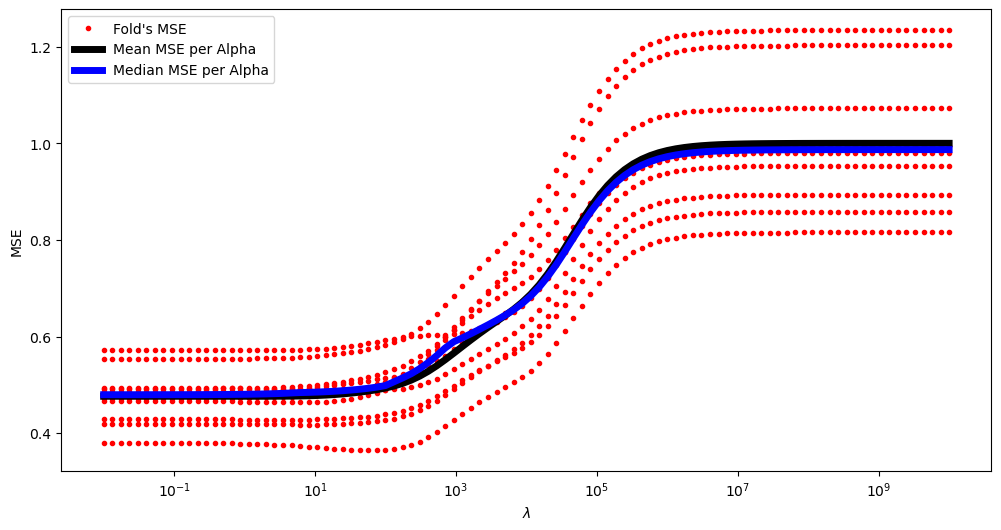

In [12]:

seed = 1
X_r1 = X_r1.values

# Determine fold division
kf = KFold(n_splits=10, random_state=random_seed, shuffle=True)

# Determine test and training data
X_rid, X_ridtest, y_rid, y_ridtest = train_test_split(X_r1, y_r1, train_size = 0.9, random_state = seed)

# Normalization of data
scaler_X = StandardScaler(with_mean=True,with_std=True).fit(X_rid)
X_rid = scaler_X.transform(X_rid)
X_ridtest = scaler_X.transform(X_ridtest)

scaler_y = StandardScaler(with_mean=True,with_std=True).fit(y_rid)
y_rid = scaler_y.transform(y_rid)

# Define variables to append results
values_ridge = pd.DataFrame(columns=['alpha', 'mse'])

# Generate 100 lambdas between 0.01 and 10**10
alphas = [10**i for i in np.linspace(start = -2, stop = 10, num = 100).tolist()]
count = 0
iter_count = 1

# K-fold cross validation of the lambda MSE
for alpha in alphas:
    for train, test in kf.split(X_rid,y_rid):

        X_train = X_rid[train]
        X_test = X_rid[test]
        y_train = y_rid[train]
        y_test = y_rid[test]
        
        
        clf = Ridge(alpha=alpha)
        clf.fit(X_train, y_train)


        y_pred = clf.predict(X_test)
        mse = metrics.mean_squared_error(y_pred,y_test)

        values_ridge.loc[count] = [alpha, mse]
        count += 1
        

# Calculate the mean MSE for each lambda
values_ridge2 = values_ridge.copy()
values_ridge2 = values_ridge2.groupby("alpha").mean().reset_index()

# Calculate the median MSE for each lambda
values_ridge3 = values_ridge.copy()
values_ridge3 = values_ridge3.groupby("alpha").median().reset_index()

# Plot the k-folds, median and mean MSE
plt.plot(values_ridge.alpha, values_ridge.mse, 'r.', label = 'Fold\'s MSE')
plt.plot(values_ridge2.alpha, values_ridge2.mse, 'k', linewidth=5.0, label = 'Mean MSE per Alpha')
plt.plot(values_ridge3.alpha, values_ridge3.mse, 'b', linewidth=5.0, label = 'Median MSE per Alpha')
plt.xscale('log')
plt.xlabel(r'$\lambda$')
plt.ylabel('MSE')
plt.legend()
plt.show()

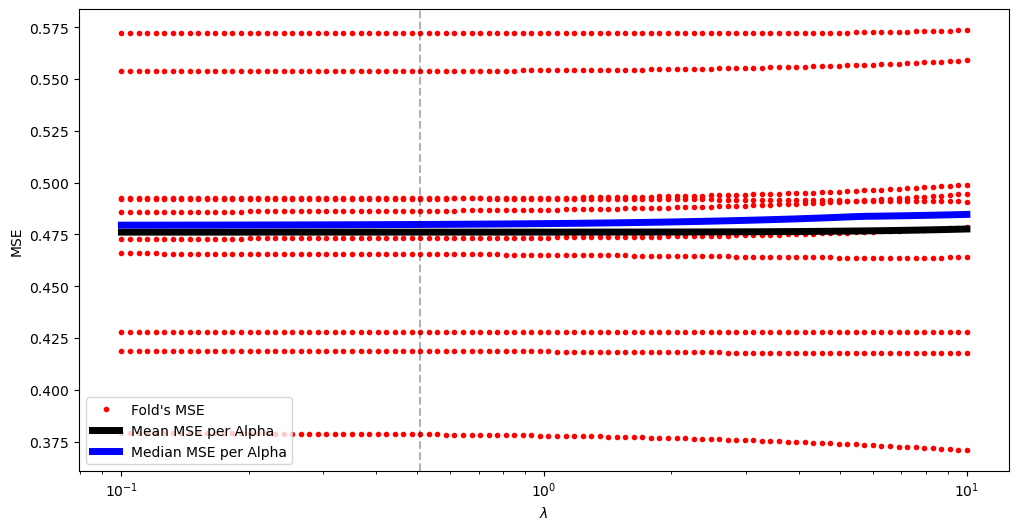

,alpha,mse
35,0.509414,0.476130
34,0.486260,0.476130
36,0.533670,0.476130
33,0.464159,0.476130
37,0.559081,0.476130
...,...,...
95,8.302176,0.477260
96,8.697490,0.477348
97,9.111628,0.477441
98,9.545485,0.477540


In [13]:
# Generate 100 lambda in the preferred region (between 0.1 and 10)
alphas = [10**i for i in np.linspace(start = -1, stop = 1, num = 100).tolist()]
count = 0
iter_count = 1
columns = X_r1_columns
Param = pd.DataFrame(columns=columns)
Alphas = pd.DataFrame(columns=['alpha'])

# K-fold cross validation of the lambda MSE
for alpha in alphas:
    for train, test in kf.split(X_rid,y_rid):

        X_train = X_rid[train]
        X_test = X_rid[test]
        y_train = y_rid[train]
        y_test = y_rid[test]
        
        
        clf = Ridge(alpha=alpha)
        clf.fit(X_train, y_train)

        
        coefficients = clf.coef_        
        
        # Step 4: Insert the NumPy array into the DataFrame
        Param.loc[count, columns] = coefficients
        Alphas.loc[count] = alpha

        
        values_ridge_coefficients = pd.concat([Alphas, Param], axis=1)

        y_pred = clf.predict(X_test)
        mse = metrics.mean_squared_error(y_pred,y_test)

        values_ridge.loc[count] = [alpha, mse]
        count += 1
        
# Calculate the mean MSE for each lambda
values_ridge2 = values_ridge.copy()
values_ridge2 = values_ridge2.groupby("alpha").mean().reset_index()
min_value = values_ridge2.sort_values(by = 'mse', ascending = True)

# Calculate the median MSE for each lambda
values_ridge3 = values_ridge.copy()
values_ridge3 = values_ridge3.groupby("alpha").median().reset_index()
best_alpha = min_value['alpha'].iloc[0]

# Plot the k-folds, median and mean MSE
plt.plot(values_ridge.alpha, values_ridge.mse, 'r.', label = 'Fold\'s MSE')
plt.plot(values_ridge2.alpha, values_ridge2.mse, 'k', linewidth=5.0, label = 'Mean MSE per Alpha')
plt.plot(values_ridge3.alpha, values_ridge3.mse, 'b', linewidth=5.0, label = 'Median MSE per Alpha')
plt.axvline(x=best_alpha, linestyle='--', color='black', alpha=0.3)
plt.xscale('log')
plt.xlabel(r'$\lambda$')
plt.ylabel('MSE')
plt.legend()
plt.show()

min_value

In [14]:
# Define variables to append results
c=0
values_mse = []
values_residuals = []

# Generate the best predictive model
best_alpha = min_value['alpha'].iloc[0] 
clf = Ridge(alpha=best_alpha)
clf.fit(X_rid, y_rid)

# Generate the predicted output and calculate the MSE and residuals
y_pred = clf.predict(X_ridtest)
y_pred = scaler_y.inverse_transform(y_pred)
residuals = y_pred - y_ridtest
mse = metrics.mean_squared_error(y_pred,y_ridtest)

# Concatonate the calculated data
data = [best_alpha, mse]
data1 = [best_alpha, y_ridtest, residuals]
values_mse.append(data)
values_residuals.append(data1)

values_mse = pd.DataFrame(values_mse , columns = ['alpha', 'mse'])
values_residuals = pd.DataFrame(values_residuals, columns = ['alpha', 'ring','residuals'])
values_residuals = values_residuals.iloc[0]

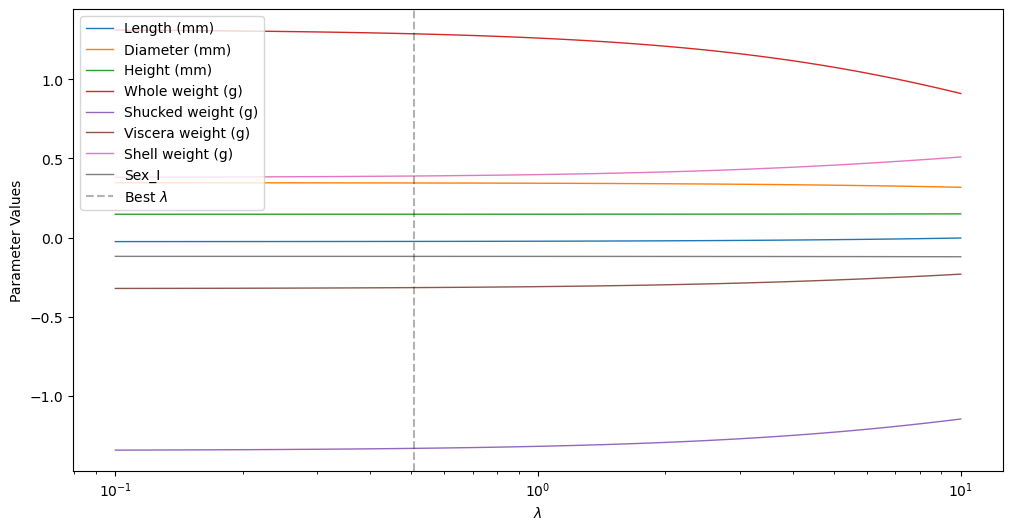

,alpha,Length (mm),Diameter (mm),Height (mm),Whole weight (g),Shucked weight (g),Viscera weight (g),Shell weight (g),Sex_I
35,0.509414,-0.024736,0.344981,0.147329,1.288515,-1.333803,-0.316895,0.389052,-0.119305


In [15]:
# Calculate the mean contribution of each feature
values_ridge_coefficients1 = values_ridge_coefficients.copy()
values_ridge_coefficients1 = values_ridge_coefficients1.groupby("alpha").mean().reset_index()

# Plot the contributions along the selected lambda
plt.plot(values_ridge_coefficients1["alpha"], values_ridge_coefficients1['Length (mm)'], label='Length (mm)', linewidth=1.0)
plt.plot(values_ridge_coefficients1["alpha"], values_ridge_coefficients1['Diameter (mm)'], label='Diameter (mm)', linewidth=1.0)
plt.plot(values_ridge_coefficients1["alpha"], values_ridge_coefficients1['Height (mm)'], label='Height (mm)', linewidth=1.0)
plt.plot(values_ridge_coefficients1["alpha"], values_ridge_coefficients1['Whole weight (g)'], label='Whole weight (g)', linewidth=1.0)
plt.plot(values_ridge_coefficients1["alpha"], values_ridge_coefficients1['Shucked weight (g)'], label='Shucked weight (g)', linewidth=1.0)
plt.plot(values_ridge_coefficients1["alpha"], values_ridge_coefficients1['Viscera weight (g)'], label='Viscera weight (g)', linewidth=1.0)
plt.plot(values_ridge_coefficients1["alpha"], values_ridge_coefficients1['Shell weight (g)'], label='Shell weight (g)', linewidth=1.0)
plt.plot(values_ridge_coefficients1["alpha"], values_ridge_coefficients1['Sex_I'], label='Sex_I', linewidth=1.0)

# Plot a line for the best alpha
best_alpha = values_mse.iloc[0]['alpha']
plt.axvline(x=best_alpha, color='k', linestyle='--', label=r'Best $\lambda$', alpha=0.3)


plt.xlabel(r'$\lambda$')
plt.ylabel('Parameter Values')
plt.xscale('log')
plt.legend(loc='upper left')
plt.show()

# Print the contribution of each feature
values_ridge_coefficients1.loc[values_ridge_coefficients1['alpha'] == best_alpha]

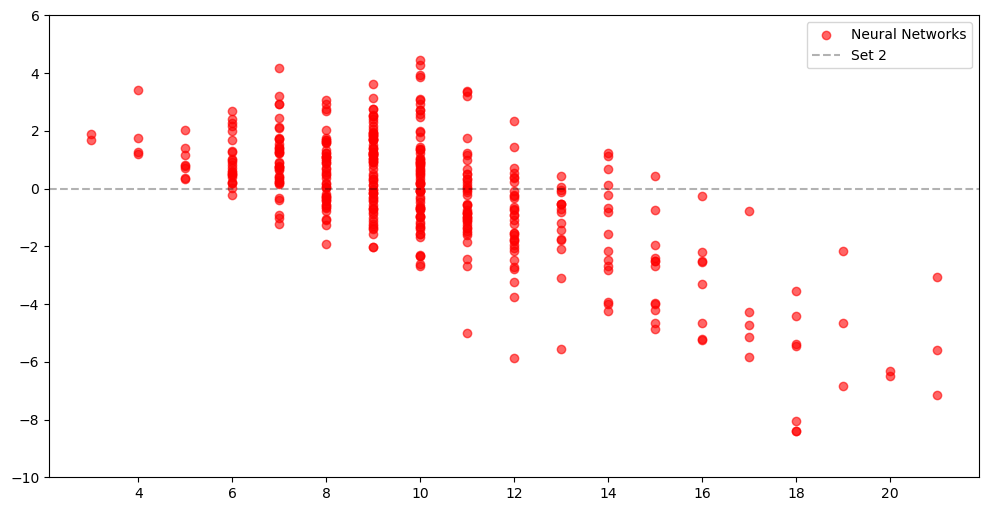

In [16]:
from matplotlib.ticker import MultipleLocator

# Plot the residuals distribution
plt.scatter(values_residuals[1], values_residuals[2], alpha=0.6, color = 'red')
plt.axhline(y=0, linestyle='--', color='black', label='y=0', alpha=0.3)
plt.ylim([-10, 6])
plt.gca().xaxis.set_major_locator(MultipleLocator(2))

plt.legend(labels=['Neural Networks', 'Set 2'], loc='upper right')
plt.show()